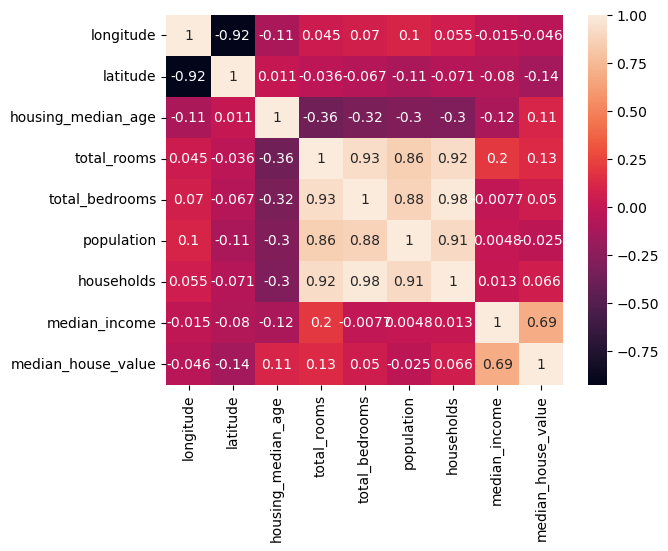

Epoch 1/150


E:\prerna\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 18.7228 - mae: 2.7269 - val_loss: 26.8395 - val_mae: 5.1209 - learning_rate: 0.0010
Epoch 2/150
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3436 - mae: 0.9165 - val_loss: 1.4573 - val_mae: 1.0109 - learning_rate: 0.0010
Epoch 3/150
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7286 - mae: 0.6782 - val_loss: 0.2535 - val_mae: 0.4082 - learning_rate: 0.0010
Epoch 4/150
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3851 - mae: 0.4897 - val_loss: 0.2296 - val_mae: 0.3960 - learning_rate: 0.0010
Epoch 5/150
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3012 - mae: 0.4326 - val_loss: 0.1109 - val_mae: 0.2563 - learning_rate: 0.0010
Epoch 6/150
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2475 - mae: 0.3919 - val_loss: 0.1466 - val_mae: 0.2984 - learning_rate: 0.0010
Epoch 7/150
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2121 - mae: 0.3623 - val_loss: 0.1562 - val_mae: 0.3147 - learning_rate: 0.0010
Epoch 8/1

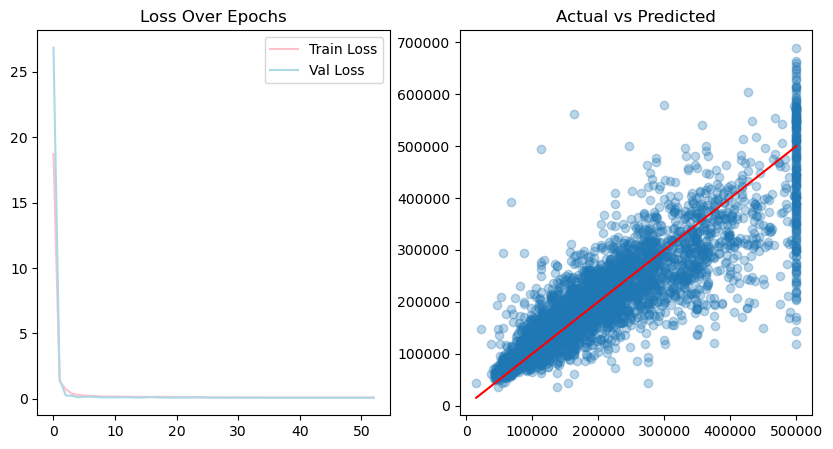

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

# 1. READ THE DATA 
df = pd.read_csv("housing.csv")

data_corr= df.select_dtypes(["float64"]).corr()

sns.heatmap(data_corr, annot= True)
plt.show()

# 2. DATA PREPROCESSING & FEATURE ENGINEERING
# Missing values handle karna
df.dropna(inplace=True)

# Naye features banana jo correlation badhate hain
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

# 3. ENCODING (One-Hot Encoding is better for ANN than Mapping)
df = pd.get_dummies(df, columns=["ocean_proximity"])

# 4. TRAIN_TEST_SPLIT
# Log transformation on Target (Price) - Isse outliers ka asar kam hota hai
x = df.drop(columns=["median_house_value"])
y = np.log1p(df["median_house_value"]) 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 5. SCALING
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# 6. BUILDING OPTIMIZED MODEL (ANN)

model = Sequential([
    Dense(128, activation="relu", input_dim=x_train.shape[1]),
    BatchNormalization(), # Training stabilize karne ke liye
    Dropout(0.2),
    
    Dense(64, activation="relu"),
    BatchNormalization(),
    
    Dense(32, activation="relu"),
    
    Dense(16, activation="relu"),
    Dense(1, activation="linear") # Output layer
])

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mae"]
)

# 7. CALLBACKS (Dynamic learning rate)
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# 8. TRAINING (Chota Batch Size = Better Accuracy)
history = model.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    epochs=150, 
    batch_size=64, 
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 9. EVALUATION
y_pred_log = model.predict(x_test)
# Wapas original scale par convert karna
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_log)

accuracy = r2_score(y_test_original, y_pred_original) * 100
print(f"Model R2 Score: {accuracy:.2f}%")

# 10. PLOTTING
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", c="pink")
plt.plot(history.history["val_loss"], label="Val Loss", c="lightblue")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_original, y_pred_original, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r')
plt.title("Actual vs Predicted")
plt.show()

# 11. PREDICTION FUNCTION (Corrected)
def get_prediction(raw_data):
    # Data preprocessing inside prediction
    # raw_data should be a list/array with same order as training columns
    data_df = pd.DataFrame([raw_data], columns=x.columns)
    scaled_data = scaler.transform(data_df)
    log_price = model.predict(scaled_data)
    return np.expm1(log_price)[0][0]



In [13]:
# 1. Dataset ki pehli row (x_test ya x se) pick karein
# Hum processed 'x' dataframe use kar rahe hain taaki columns match karein
first_row_features = x.iloc[4].values 

# 2. Prediction function call karein
predicted_price = get_prediction(first_row_features)

# 3. Actual value (y) ko wapas log se original price mein laayein
# Kyunki y = np.log1p(df["median_house_value"]) kiya tha
actual_price = np.expm1(y.iloc[4]) 

print(f"--- First Row Prediction ---")
print(f"Actual Price:    {actual_price:,.2f}")
print(f"Predicted Price: {predicted_price:,.2f}")
print(f"Difference:      {abs(actual_price - predicted_price):,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
--- First Row Prediction ---
Actual Price:    342,200.00
Predicted Price: 241,735.86
Difference:      100,464.14


In [15]:
# 12. SAVE MODEL & SCALER
model.save("best_housing_model.h5")
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Features list ko save kar lein prediction mein kaam aayega
with open('features.pkl', 'wb') as f:
    pickle.dump(x.columns.tolist(), f)

In [16]:
print(x.columns.tolist())
# Output mein jo list aaye, wahi Flask mein order hona chahiye.

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
